# Decompositions shootout

We will compare the following matrix decompositions:

* singular value decomposition (SVD)
* non-negative matrix factorization (NMF)
* interpolative decomposition (ID)
* CUR decomposition

All these decompositions are trying to build a low-rank approximation of the matrix $A \in \mathbb{R}^{n \times m}$ with matrices $W \in \mathbb{R}^{n \times r}$, $H \in \mathbb{R}^{r \times m}$ s.t. $r \ll n, r \ll m$ and 
$\| A - W H \|_\mathrm{F}$ is minimized.

In [1]:
%%capture

from keras.datasets import fashion_mnist, mnist
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.linalg.interpolative
import sklearn.decomposition
from cur import CUR

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
def flatten(x, image_size=28):
    return x.reshape(image_size * image_size, x.shape[-1])

In [3]:
def unflatten(x_flat, image_size=28):
    return x_flat.reshape(image_size, image_size, x_flat.shape[-1])

In [4]:
def relative_error(exact, approx):
    return np.linalg.norm(exact - approx) / np.linalg.norm(exact)

In [5]:
data_limit = 5000

(x, _), _ = mnist.load_data()
x = x[:data_limit, :, :]
x = np.moveaxis(x, 0, 2)
x_flat = flatten(x)

residual = {}

In [6]:
def plot_examples(data, num_rows, num_columns, cmap=None):
    if cmap is None:
        cmap = cm.gray_r
    f, ax = plt.subplots(num_rows, num_columns, figsize=(12, 5))
    for i in range(num_rows):
        for j in range(num_columns):
            ax[i, j].imshow(data[:, :, i * num_columns + j], cmap=cmap)
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

In [7]:
def svd(data, target_rank):
    u, s, vh = np.linalg.svd(data)
    basis = u[:, :target_rank]
    coefficients = s[:target_rank, np.newaxis] * vh[:target_rank, :]
    return basis, coefficients

In [8]:
def nmf(data, target_rank):
    model = sklearn.decomposition.NMF(
        n_components=target_rank,
        init="random",
        random_state=777,
        )
    basis = model.fit_transform(data)
    coefficients = model.components_
    return basis, coefficients

In [9]:
def interp_decomp(data, target_rank):
    idx, proj = sp.linalg.interpolative.interp_decomp(data.astype(np.float64), target_rank)
    basis = data[:, idx[:target_rank]]
    coefficients = np.hstack([np.eye(proj.shape[0]), proj])[:, np.argsort(idx)]
    return basis, coefficients

In [10]:
def cur(data, target_rank):
    model = CUR(data, rrank=target_rank, crank=target_rank)
    model.factorize()
    basis = model.U
    coefficients = model.S @ model.V
    return basis, coefficients

# Ground truth

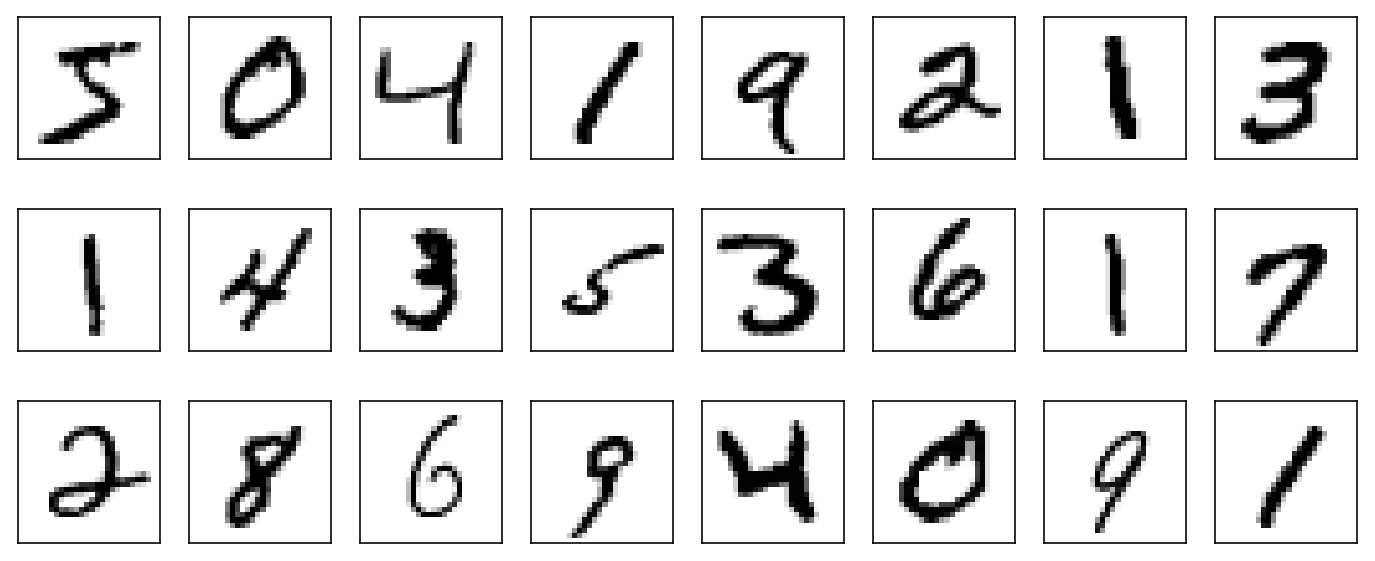

In [11]:
plot_examples(x, 3, 8)

In [12]:
_, sigma, _ = np.linalg.svd(x_flat)

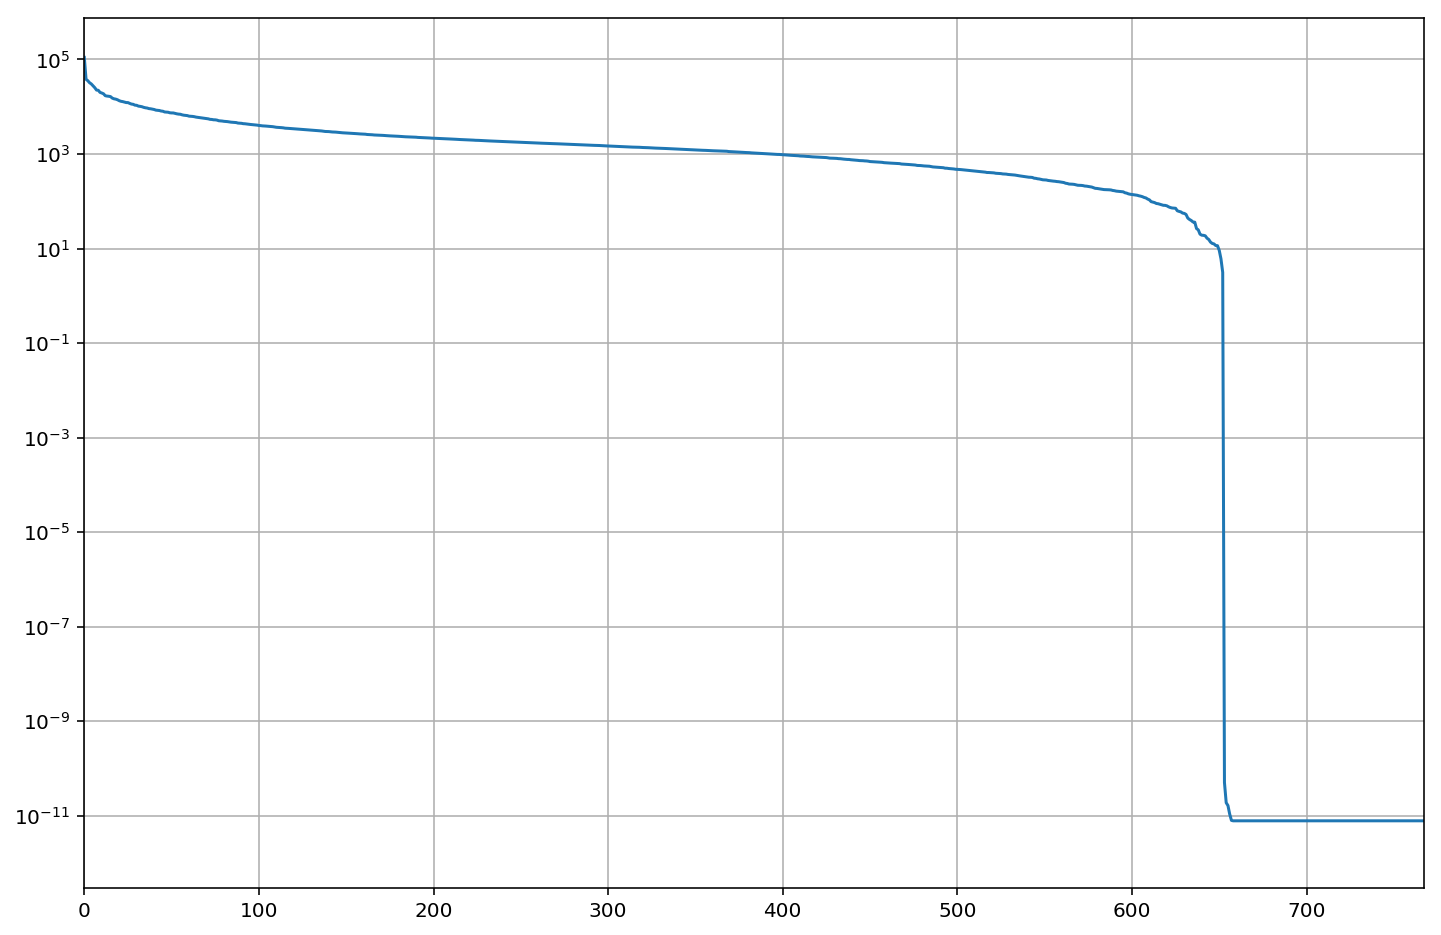

In [13]:
plt.figure(figsize=(12, 8))
plt.semilogy(sigma)
plt.xlim([0, 767])
plt.grid()
plt.show()

# SVD

In [14]:
%%time
tall_svd, fat_svd = svd(x_flat, 24)

CPU times: user 18.2 s, sys: 2.68 s, total: 20.9 s
Wall time: 5.85 s


Relative Frobenius norm of the residual: 4.80e-01


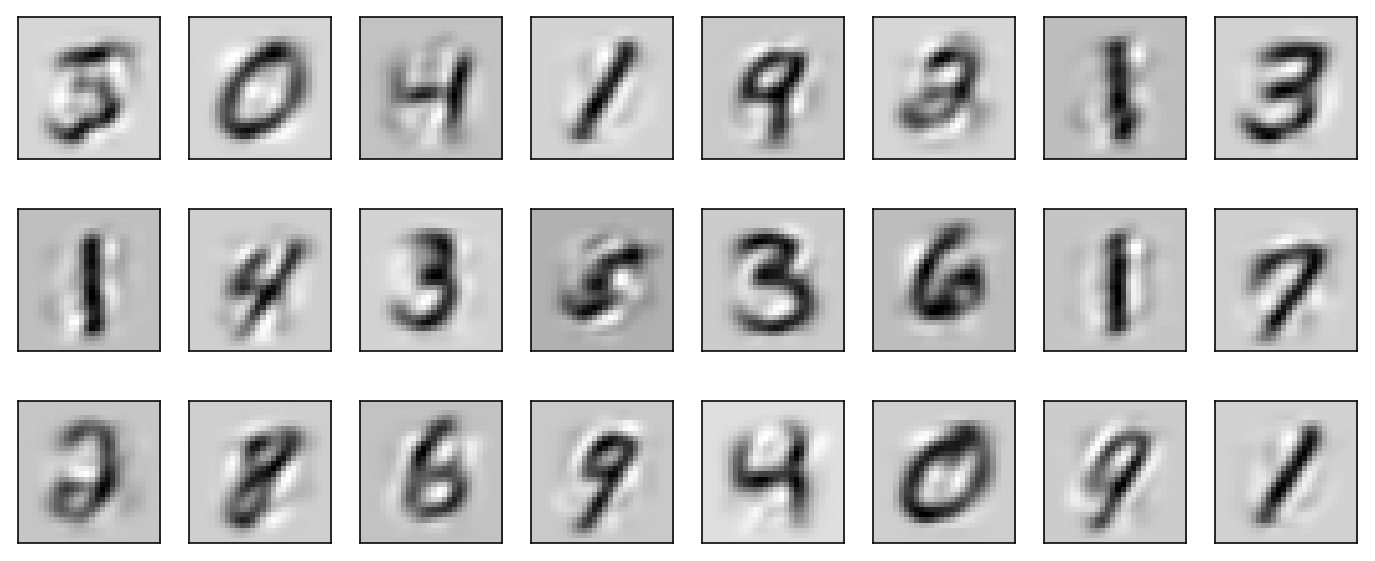

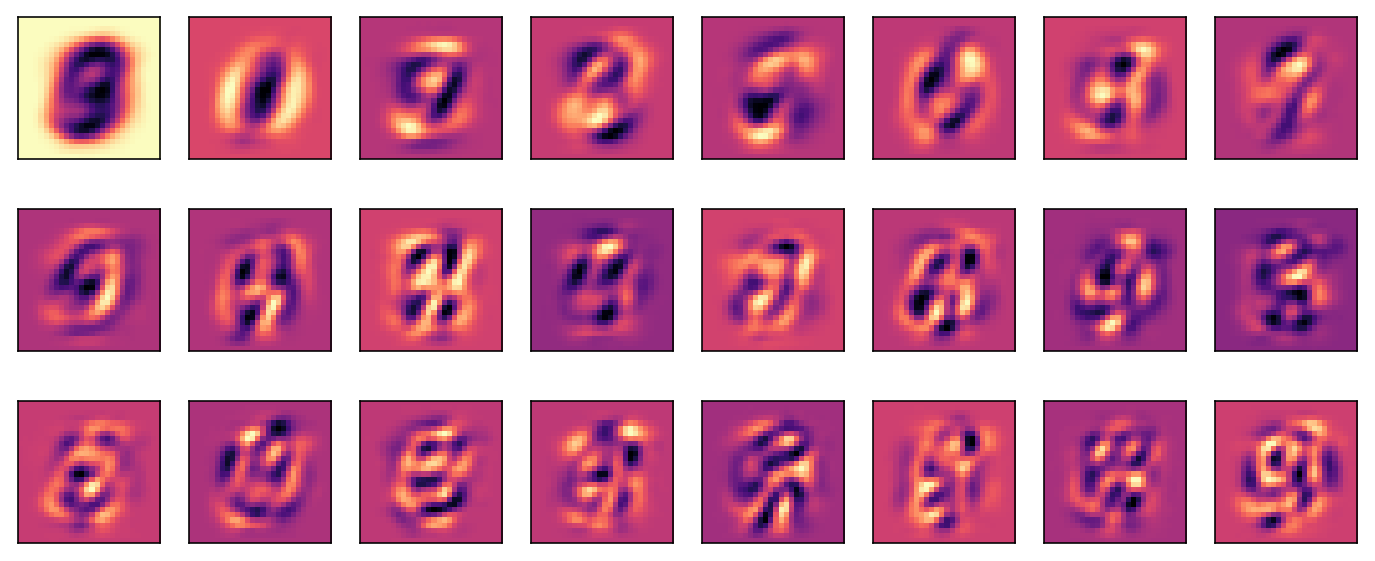

In [15]:
plot_examples(unflatten(tall_svd @ fat_svd), 3, 8)
plot_examples(unflatten(tall_svd), 3, 8, cmap=cm.magma)
residual["SVD"] = relative_error(tall_svd @ fat_svd, x_flat)
print(f'Relative Frobenius norm of the residual: {residual["SVD"]:.2e}')

# NMF

In [16]:
%%time
tall_nmf, fat_nmf = nmf(x_flat, 24)

CPU times: user 19.8 s, sys: 5.34 s, total: 25.2 s
Wall time: 6.77 s


Relative Frobenius norm of the residual: 5.68e-01


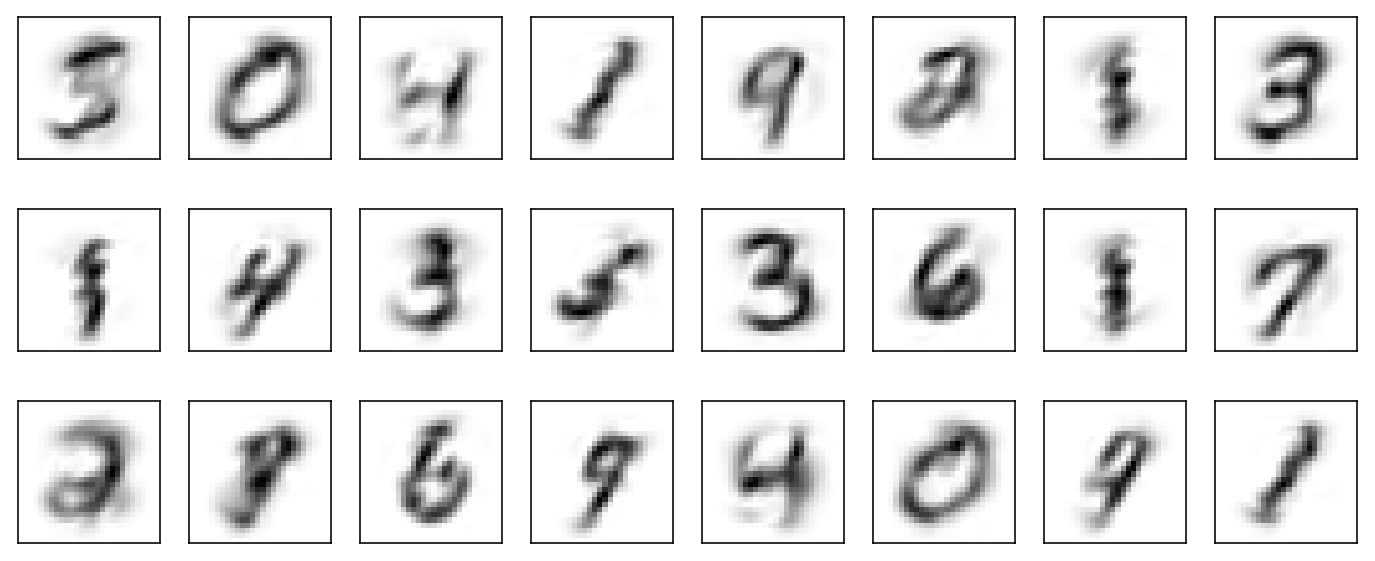

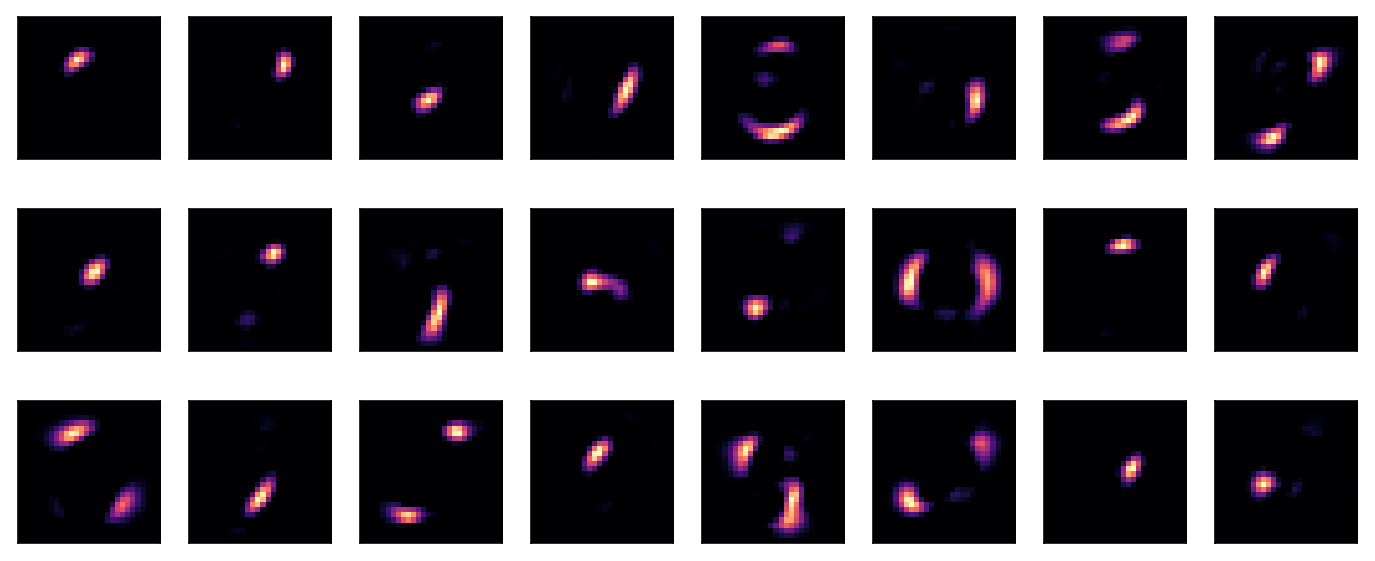

In [17]:
plot_examples(unflatten(tall_nmf @ fat_nmf), 3, 8)
plot_examples(unflatten(tall_nmf), 3, 8, cmap=cm.magma)
residual["NMF"] = relative_error(tall_nmf @ fat_nmf, x_flat)
print(f'Relative Frobenius norm of the residual: {residual["NMF"]:.2e}')

# ID

In [18]:
%%time
tall_id, fat_id = interp_decomp(flatten(x), 24)

CPU times: user 100 ms, sys: 4 ms, total: 104 ms
Wall time: 102 ms


Relative Frobenius norm of the residual: 8.74e-01


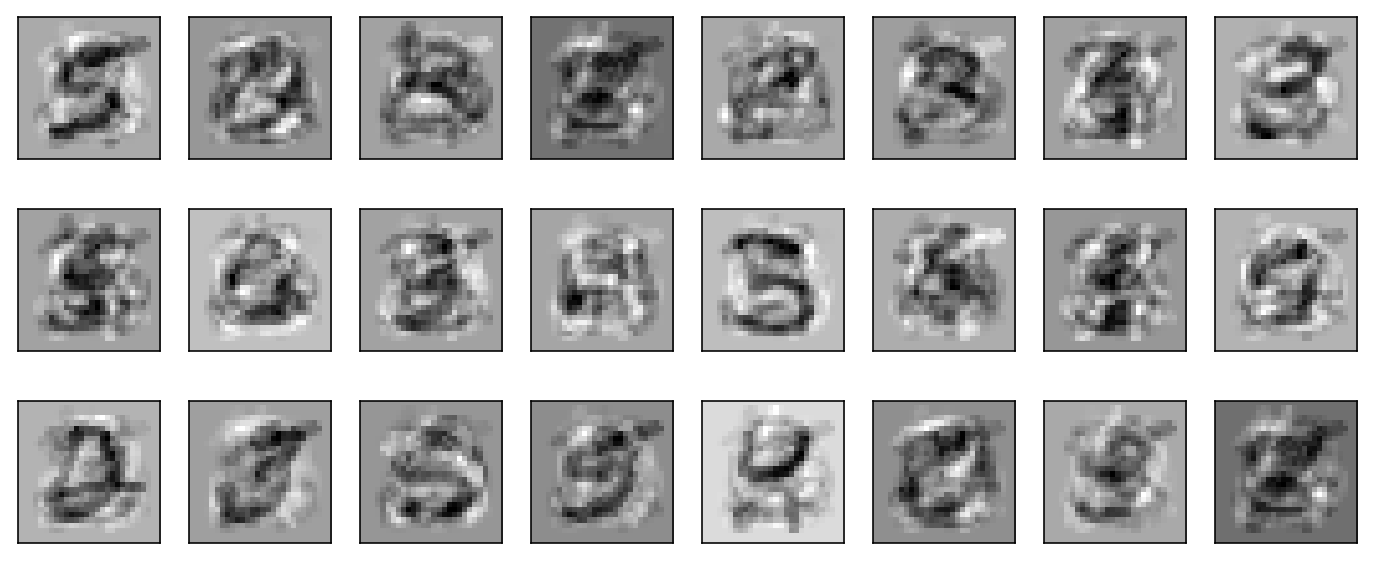

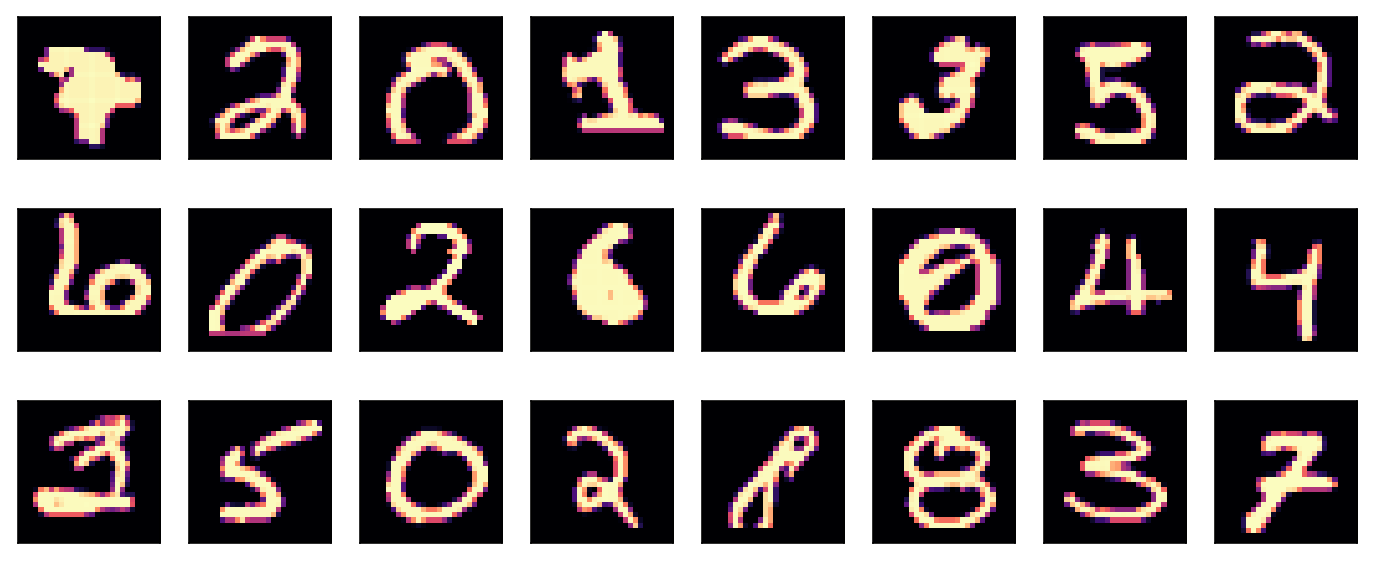

In [19]:
plot_examples(unflatten(tall_id @ fat_id), 3, 8)
plot_examples(unflatten(tall_id), 3, 8, cmap=cm.magma)
residual["ID"] = relative_error(tall_id @ fat_id, x_flat)
print(f'Relative Frobenius norm of the residual: {residual["ID"]:.2e}')

# CUR

In [20]:
np.random.seed(777)

In [21]:
%%time
tall_cur, fat_cur = cur(flatten(x), 24)

CPU times: user 120 ms, sys: 72 ms, total: 192 ms
Wall time: 66.4 ms


Relative Frobenius norm of the residual: 9.12e-01


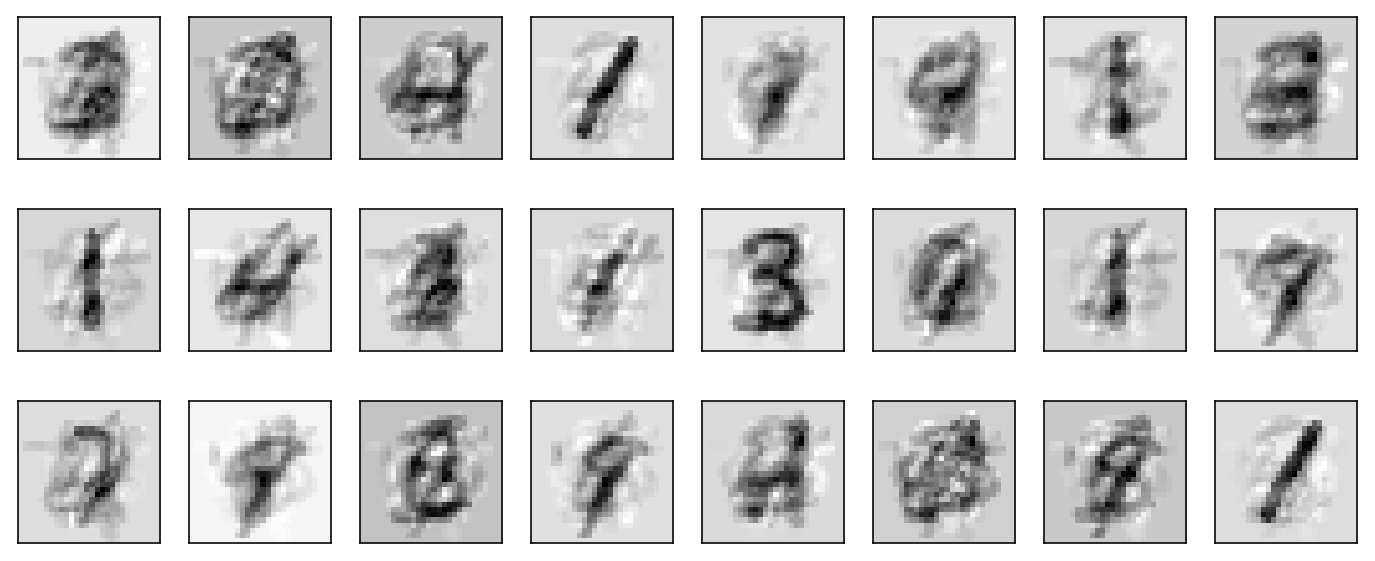

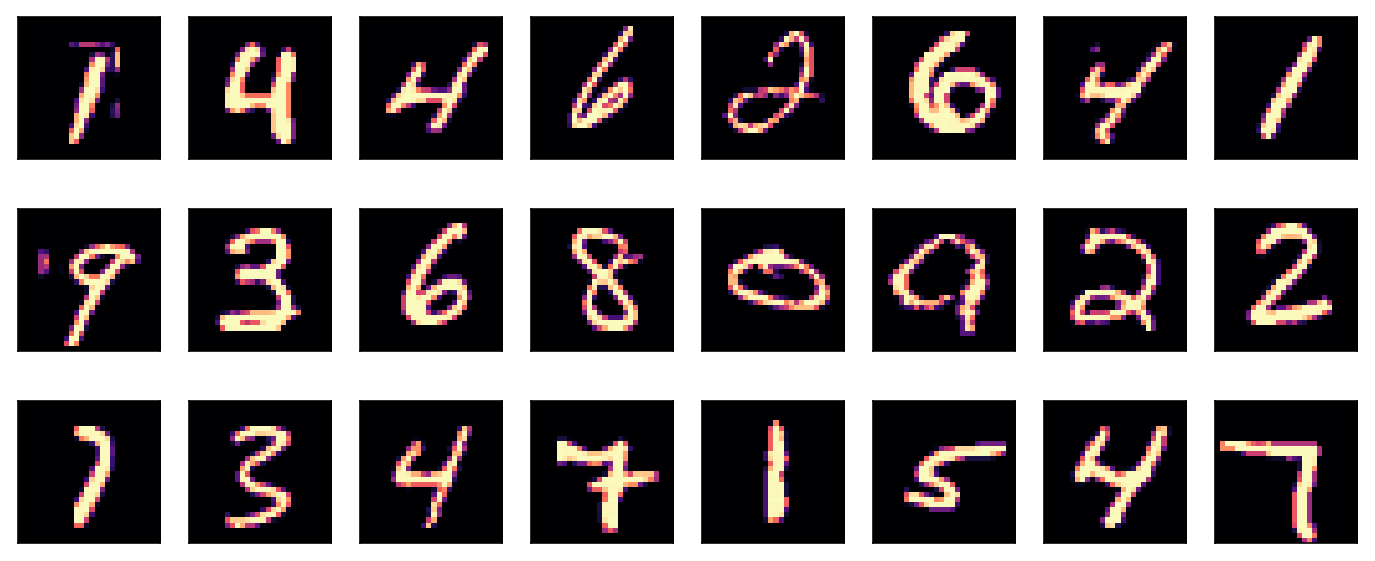

In [22]:
plot_examples(unflatten(tall_cur @ fat_cur), 3, 8)
plot_examples(unflatten(tall_cur), 3, 8, cmap=cm.magma)
residual["CUR"] = relative_error(tall_cur @ fat_cur, x_flat)
print(f'Relative Frobenius norm of the residual: {residual["CUR"]:.2e}')

# Residuals comparison

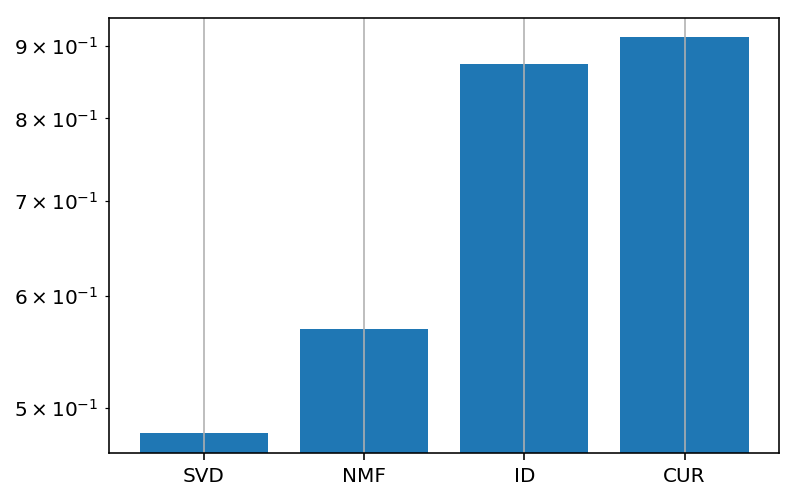

In [25]:
plt.bar(range(len(residual)), list(residual.values()), align="center")
plt.xticks(range(len(residual)), list(residual.keys()))
plt.gca().set_yscale("log")
plt.grid()
plt.show()